In [356]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
from sklearn.metrics import accuracy_score,classification_report, mean_absolute_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
np.random.seed(123)
import sklearn as sk
#from sklearn.svm import SVR
from model import SVR
from torch.utils.data import Dataset
import time

In [357]:
filepath = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/1.csv"
columnName="delta_t"
rate= 0.6 #0.5915
lookBack = 21
C = 100
epsilon = 0.01
gamma = 0.1
RMSE_mean = 0
MAE_mean = 0

# Load Data


In [358]:
def load_data(filename, columnName,plot):

    df = pd.read_csv(filename, index_col=0, parse_dates=True)
    df = df.fillna(0)

    data_date = [date for date in df.index]
    data_date = np.array(data_date)
    data_date = data_date.reshape(-1, 1)

    ts = df[columnName]
    data = ts.values.reshape(-1, 1).astype("float32")  # (N, 1)
    print("time series shape:", data.shape)

    num_data_points = len(data_date)

    if plot:
        road = (filename.split('/')[-1]).split('.')[0]
        path = filename.split('/')[-2]
            
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data, color= '#001f3f') 
        plt.title(f"Travel time of truck in road {road} and path {path}, from {data_date[0][0]} to {data_date[num_data_points - 1][0]}")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.show()
    return ts, data,data_date,num_data_points

time series shape: (7413, 1)


C:\Users\Niracha\anaconda3\envs\travel_time\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


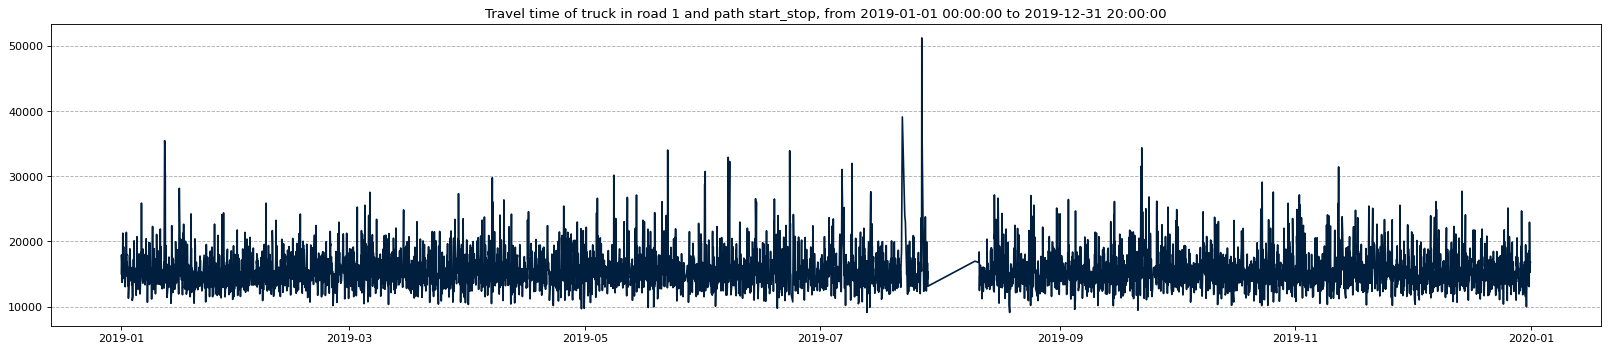

In [359]:

ts, data,date,num_data_points = load_data(filepath, columnName=columnName,plot =True)

# Normalize time series and train test split

In [360]:
# divide training and testing, default as 3:1
def divideTrainTest(dataset,date,num_data_points, rate=0.75,plot=False):

     # init split index
    split_train_index = int(dataset.shape[0] * rate)
    split_val_index = int(dataset.shape[0] * (rate + 0.2))

   
    train,val, test = dataset[0:split_train_index],dataset[split_train_index: split_val_index ] ,dataset[ split_val_index :]
   

    if plot:
        road = (filepath.split('/')[-1]).split('.')[0]
        path = filepath.split('/')[-2]

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)
        to_plot_data_y_test = np.zeros(num_data_points)
        

        to_plot_data_y_train[0:split_train_index] = scaler.inverse_transform(train.reshape(1, -1))
        to_plot_data_y_val[split_train_index: split_val_index ] = scaler.inverse_transform(val.reshape(1, -1))
        to_plot_data_y_test[ split_val_index :] = scaler.inverse_transform(test.reshape(1, -1))

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
        to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(date, to_plot_data_y_train, label='travel time (train)', color='#3D9970')
        plt.plot(date, to_plot_data_y_val, label='travel time (validation)', color='#0074D9')
        plt.plot(date, to_plot_data_y_test, label='travel time (test)', color='#FF4136')

        plt.title(f"Travel time of truck in rode {road} ({path}) - show traning and validation data")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()
    
    return train, test

# Prepare Data

In [361]:
class TravelTimeDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2)
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

In [362]:
def preprocess(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)


def generate_data(normalize_data, data_date, num_data_points, scaler, cfg, plot=False):
    data_x, data_y = preprocess(normalize_data, cfg['data']['window_size'])

    # init split index
    split_train_index = int(data_x.shape[0] * cfg['data']['train_split_size'])
    split_val_index = int(data_x.shape[0] * (cfg['data']['train_split_size'] + cfg['data']['val_split_size']))

    # split data for train test model
    # split data x
    data_x_train = data_x[:split_train_index]
    data_x_val = data_x[split_train_index:split_val_index]
    data_x_test = data_x[split_val_index:]

    # split data y
    data_y_train = data_y[:split_train_index]
    data_y_val = data_y[split_train_index:split_val_index]
    data_y_test = data_y[split_val_index:]

    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)
        to_plot_data_y_test = np.zeros(num_data_points)

        to_plot_data_y_train[cfg['data']['window_size']:split_train_index + cfg['data']['window_size']] = scaler.inverse_transform(data_y_train.reshape(1, -1))
        to_plot_data_y_val[split_train_index + cfg['data']['window_size']:split_val_index + cfg['data']['window_size']] = scaler.inverse_transform(data_y_val.reshape(1, -1))
        to_plot_data_y_test[split_val_index + cfg['data']['window_size']:] = scaler.inverse_transform(data_y_test.reshape(1, -1))

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
        to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

        # plot
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, to_plot_data_y_train, label='travel time (train)', color=cfg['plots']['color_train'])
        plt.plot(data_date, to_plot_data_y_val, label='travel time (validation)', color=cfg['plots']['color_val'])
        plt.plot(data_date, to_plot_data_y_test, label='travel time (test)', color=cfg['plots']['color_test'])

        plt.title(f"Travel time of truck in rode {road} ({path}) - show traning, test and validation data")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return data_x_train, data_x_val, data_x_test, data_y_train, data_y_val, data_y_test, split_train_index, split_val_index

C:\Users\Niracha\anaconda3\envs\travel_time\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


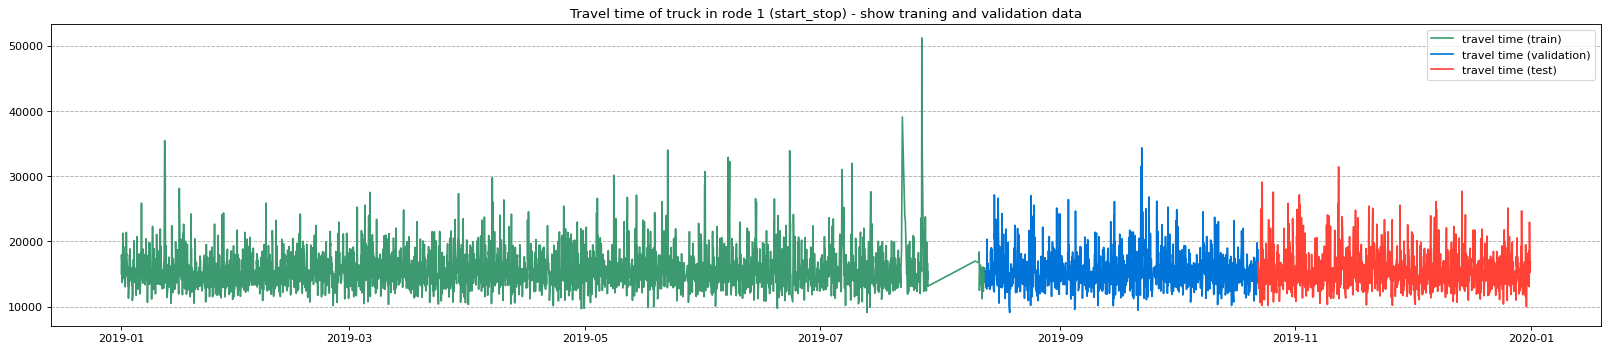

In [363]:
# normalize time series
scaler = StandardScaler() # MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)


# divide the series into training/testing samples
train,test = divideTrainTest(dataset,date,num_data_points,rate=rate,plot=True)


# Create Samples x,y from data

In [364]:
# divide ts as training/testing samples, looBack is lag window
def createSamples(dataset, lookBack):

    dataX, dataY = [], []
    for i in range(len(dataset) - lookBack):
        sample_X = dataset[i:(i + lookBack), :]
        sample_Y = dataset[i + lookBack, :] 
        dataX.append(sample_X)
        dataY.append(sample_Y)
    dataX = np.array(dataX)  # (N, lag, 1)
    dataY = np.array(dataY)  # (N, 1)
    
    dataX = np.reshape(dataX, (dataX.shape[0], dataX.shape[1]))

    return dataX, dataY

In [365]:
trainX, trainY = createSamples(train, lookBack)
testX, testY = createSamples(test, lookBack)

# SVR Model

In [366]:
def SVR_forecasting(trainX,trainY,testX,testY,C=2.0, epsilon=0.01,gamma = 0.15):

    #find parameter
    # print(gridSearch(trainX, trainY))
    # SVRModel = SVR(C=C, cache_size=200, coef0=0.0, degree=3, epsilon=epsilon, gamma=gamma,
    #                      kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
    # SVRModel.fit(trainX, trainY)

    # buil model and train

    SVRModel = SVR.SVRModel(C=C, epsilon=epsilon,gamma=gamma)
    startTime = time.time()
    SVRModel.train(trainX, trainY)
    trainTime = time.time()-startTime

    # forecasting
    trainPred = SVRModel.predict(trainX)
    startTestTime = time.time()
    testPred = SVRModel.predict(testX)
    testTime = time.time()-startTestTime
    
    # # reverse the time series
    # trainPred = scaler.inverse_transform(trainPred)
    # trainY = scaler.inverse_transform(trainY)
    # testPred = scaler.inverse_transform(testPred)
    # testY = scaler.inverse_transform(testY)

   
    

    # evaluate
    MAE = calcMAE(scaler.inverse_transform(testY), scaler.inverse_transform(testPred.reshape(-1, 1)))
    RMSE = calcRMSE(scaler.inverse_transform(testY), scaler.inverse_transform(testPred.reshape(-1, 1)))
    MSE = calcMSE(scaler.inverse_transform(testY), scaler.inverse_transform(testPred.reshape(-1, 1)))
    MAPE = calcMAPE(scaler.inverse_transform(testY), scaler.inverse_transform(testPred.reshape(-1, 1)))
    SMAPE = calcSMAPE(scaler.inverse_transform(testY), scaler.inverse_transform(testPred.reshape(-1, 1)))

   

    print(f"MSE : {MSE}")
    print(f"RMSE : {RMSE}")
    print(f"MAE : {MAE}")
    print(f"TrainTime : {trainTime}")
    print(f"TestTime : {testTime}")

    
        

    return trainPred,testPred,MSE,RMSE, MAE

def calcRMSE(true,pred):
    return np.sqrt(mean_squared_error(true, pred))

def calcMSE(true,pred):
    return mean_squared_error(true, pred)

def calcMAE(true,pred):
    return mean_absolute_error(true, pred)



def calcMAPE(true, pred, epsion = 0.0000000):

    true += epsion
    return np.sum(np.abs((true-pred)/true))/len(true)*100



def calcSMAPE(true, pred):
    delim = (np.abs(true)+np.abs(pred))/2.0
    return np.sum(np.abs((true-pred)/delim))/len(true)*100

def gridSearch(x,y):
    param_grid ={'C':[0.1,1,10,100,1000],'gamma':[1,0.1,0.01,0.001],'kernel':['rbf'],'epsilon':[1,0.1,0.01,0.001],}
    grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=100)
    grid.fit(x,y)
    
    return grid.best_params_
    

In [367]:


def plot(dataset,date,predicted_train,predicted_val,trainY,testY,MSE,RMSE, MAE,rate):
   
    train_size = int(len(dataset) * (rate+0.2))
    # to_plot_data_y_train_pred = np.zeros(num_data_points)
    # to_plot_data_y_val_pred = np.zeros(num_data_points)
    
    

    # to_plot_data_y_train_pred[lookBack:train_size] = scaler.inverse_transform(predicted_train.reshape(1, -1))
    # to_plot_data_y_val_pred[train_size+lookBack:] = scaler.inverse_transform(predicted_val.reshape(1, -1))

    # to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    # to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # to_plot_data_y_train = np.zeros(num_data_points)
    # to_plot_data_y_val = np.zeros(num_data_points)
        

    # to_plot_data_y_train[lookBack:train_size] = scaler.inverse_transform(trainY.reshape(1, -1))
    # to_plot_data_y_val[train_size+lookBack:] = scaler.inverse_transform(testY.reshape(1, -1))

    # to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
    # to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

    # # plot
    # fig = plt.figure(figsize=(25, 5), dpi=80)
    # fig.patch.set_facecolor((1.0, 1.0, 1.0))
    # plt.plot(date, to_plot_data_y_train, label='Actual travel time', color='#001f3f')
    # plt.plot(date, to_plot_data_y_val, label='Actual travel time', color='#001f3f')
    # plt.plot(date, to_plot_data_y_train_pred, label='Predicted travel time (train)', color='#3D9970')
    # plt.plot(date, to_plot_data_y_val_pred, label='Predicted travel time (validation)', color='#0074D9')
    # plt.title(f"Compare predicted travel time to actual travel time")
    # plt.grid(b=None, which='major', axis='y', linestyle='--')
    # plt.legend()
    # plt.show()

    # prepare data for plotting, zoom in validation
    to_plot_data_y_val_subset = scaler.inverse_transform(testY.reshape(-1, 1))
    to_plot_predicted_val = scaler.inverse_transform(predicted_val.reshape(-1, 1))
    to_plot_data_date = date[train_size+lookBack:]

    #plot
    fig = plt.figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label='Actual travel time', color='#001f3f')
    plt.plot(to_plot_data_date, to_plot_predicted_val, label='Predicted travel time (validation)', color='#FF4136')
    plt.title(f"Zoom in to examine predicted travel time on validation data portion [MSE: {MSE:.3f} | RMSE: {RMSE:.3f} | MAE: {MAE:.3f}]")
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

# Model Training

In [368]:
#trainPred, testPred,MSE,RMSE, MAE = SVR_forecasting(trainX, trainY, testX, testY, C=C, epsilon=epsilon,gamma = gamma)
#plot(data,date,trainPred,testPred,testY,MSE,RMSE, MAE,rate)

In [369]:
# predict road
filepath_road1 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/1.csv"
filepath_road2 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/2.csv"
filepath_road4 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/4.csv"
filepath_road7 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/7.csv"
filepath_road9 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/9.csv"
filepath_road32 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/32.csv"
filepath_road35 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/35.csv"
filepath_road41 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/41.csv"
filepath_road304 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/304.csv"
filepath_road331 = "G:/.shortcut-targets-by-id/1BPVt5iZdUsmzOQzvMyGKVLyZlLZoLSDc/Travel Time Data/time_series_clean/start_stop/331.csv"

def predictTime(filepath,RMSE_mean,MAE_mean):
    ts, data,date,num_data_points = load_data(filepath, columnName=columnName,plot =False)
    # normalize time series
    scaler = StandardScaler() # MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(data)
    # divide the series into training/testing samples
    train,test = divideTrainTest(dataset,date,num_data_points,rate=rate,plot=False)
    trainX, trainY = createSamples(train, lookBack)
    testX, testY = createSamples(test, lookBack)
    trainPred, testPred,MSE,RMSE, MAE = SVR_forecasting(trainX, trainY, testX, testY, C=C, epsilon=epsilon,gamma = gamma)
    RMSE_mean += RMSE;
    MAE_mean += MAE;
    road = (filepath.split('/')[-1]).split('.')[0]
    path = filepath.split('/')[-2]
            
    print("Travel time of truck in road : "+road)
    
   # plot(data,date,trainPred,testPred,trainY,testY,MSE,RMSE, MAE,rate)
    print()
    print('///////////////////////////////////////////////////////////////////////////////////////')
    return RMSE_mean,MAE_mean


In [370]:
RMSE_mean,MAE_mean = predictTime(filepath_road1,RMSE_mean,MAE_mean)
RMSE_mean,MAE_mean = predictTime(filepath_road2,RMSE_mean,MAE_mean)
RMSE_mean,MAE_mean = predictTime(filepath_road4,RMSE_mean,MAE_mean)
RMSE_mean,MAE_mean = predictTime(filepath_road7,RMSE_mean,MAE_mean)
RMSE_mean,MAE_mean = predictTime(filepath_road9,RMSE_mean,MAE_mean)
RMSE_mean,MAE_mean = predictTime(filepath_road32,RMSE_mean,MAE_mean)
RMSE_mean,MAE_mean = predictTime(filepath_road35,RMSE_mean,MAE_mean)
RMSE_mean,MAE_mean = predictTime(filepath_road41,RMSE_mean,MAE_mean)
RMSE_mean,MAE_mean = predictTime(filepath_road304,RMSE_mean,MAE_mean)
RMSE_mean,MAE_mean = predictTime(filepath_road331,RMSE_mean,MAE_mean)

RMSE_mean = RMSE_mean/10
MAE_mean = MAE_mean/10

print(f"RMSE_mean : {RMSE_mean}")
print(f"MAE_mean : {MAE_mean}")

time series shape: (7413, 1)


C:\Users\Niracha\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE : 9962494.826863864
RMSE : 3156.3420009346046
MAE : 2369.1491922331857
TrainTime : 3.863428831100464
TestTime : 0.5531234741210938
Travel time of truck in road : 1

///////////////////////////////////////////////////////////////////////////////////////
time series shape: (7413, 1)


C:\Users\Niracha\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE : 9988157.532350995
RMSE : 3160.4046469322557
MAE : 2364.7106158986385
TrainTime : 4.417988300323486
TestTime : 0.5501236915588379
Travel time of truck in road : 2

///////////////////////////////////////////////////////////////////////////////////////
time series shape: (7413, 1)


C:\Users\Niracha\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE : 11368813.853333302
RMSE : 3371.7671706885844
MAE : 2524.813849784744
TrainTime : 3.3112502098083496
TestTime : 0.588132381439209
Travel time of truck in road : 4

///////////////////////////////////////////////////////////////////////////////////////
time series shape: (7413, 1)


C:\Users\Niracha\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE : 7901994.497218102
RMSE : 2811.048647252143
MAE : 2136.164559349111
TrainTime : 2.6496050357818604
TestTime : 0.5501232147216797
Travel time of truck in road : 7

///////////////////////////////////////////////////////////////////////////////////////
time series shape: (7413, 1)


C:\Users\Niracha\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE : 13796438.615524897
RMSE : 3714.355747034053
MAE : 2583.8386615868894
TrainTime : 12.254236936569214
TestTime : 0.5221168994903564
Travel time of truck in road : 9

///////////////////////////////////////////////////////////////////////////////////////
time series shape: (7413, 1)


C:\Users\Niracha\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE : 14974626.06497443
RMSE : 3869.706198792672
MAE : 2180.6734527018416
TrainTime : 16.11922550201416
TestTime : 0.5511372089385986
Travel time of truck in road : 32

///////////////////////////////////////////////////////////////////////////////////////
time series shape: (7413, 1)


C:\Users\Niracha\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE : 13239819.504152326
RMSE : 3638.6562772749403
MAE : 2562.572949791101
TrainTime : 7.699897527694702
TestTime : 0.5271177291870117
Travel time of truck in road : 35

///////////////////////////////////////////////////////////////////////////////////////
time series shape: (7413, 1)


C:\Users\Niracha\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE : 10908019.690379083
RMSE : 3302.7291276123574
MAE : 2341.7105706551533
TrainTime : 6.20696234703064
TestTime : 0.5506305694580078
Travel time of truck in road : 41

///////////////////////////////////////////////////////////////////////////////////////
time series shape: (7413, 1)


C:\Users\Niracha\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE : 19395754.54452339
RMSE : 4404.061142232631
MAE : 2760.9282422065326
TrainTime : 11.322602987289429
TestTime : 0.5541245937347412
Travel time of truck in road : 304

///////////////////////////////////////////////////////////////////////////////////////
time series shape: (7413, 1)


C:\Users\Niracha\anaconda3\envs\travel_time\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE : 14110523.547023747
RMSE : 3756.3976822247864
MAE : 2618.8733198906457
TrainTime : 13.761651515960693
TestTime : 0.530118465423584
Travel time of truck in road : 331

///////////////////////////////////////////////////////////////////////////////////////
RMSE_mean : 3518.546864097903
MAE_mean : 2444.343541409784
